In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False  

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.inspection import permutation_importance

import shap

In [2]:
data = pd.read_csv(os.getcwd()+'\\data\\ABOX_raw_features_eb.csv')
print(data.shape)
data.head()

(1341, 73)


,material_id,pretty_formula,full_formula,unit_cell_formula,density,spacegroup.crystal_system,volume,band_gap,formation_energy_per_atom,e_above_hull,...,gamma,nA,nB,nX,rA,rB,rX,mu,t,tau
0,mp-10250,BaLiF3,Ba1Li1F3,"{'Ba': 1.0, 'Li': 1.0, 'F': 3.0}",5.020980,0,66.561793,6.5716,-3.767297,0.014824,...,90.000000,2.0,1.0,-1.0,1.61,0.76,1.33,0.571429,0.994686,3.394073
1,mp-1097061,CaTlF3,Ca1Tl1F3,"{'Ca': 1.0, 'Tl': 1.0, 'F': 3.0}",5.456459,2,91.740879,4.8393,-3.321972,0.018100,...,89.962853,1.0,2.0,-1.0,1.70,1.00,1.33,0.751880,0.919542,3.533750
2,mp-998150,CaTlF3,Ca1Tl1F3,"{'Ca': 1.0, 'Tl': 1.0, 'F': 3.0}",5.446106,3,91.915271,4.8398,-3.321913,0.018159,...,90.090621,1.0,2.0,-1.0,1.70,1.00,1.33,0.751880,0.919542,3.533750
3,mp-12262,CsBeF3,Cs4Be4F12,"{'Cs': 4.0, 'Be': 4.0, 'F': 12.0}",3.397007,3,388.933579,6.6615,-3.425382,0.000000,...,90.000000,1.0,2.0,-1.0,1.88,0.45,1.33,0.338346,1.275176,4.877529
4,mp-1017555,CsBeF3,Cs1Be1F3,"{'Cs': 1.0, 'Be': 1.0, 'F': 3.0}",5.026564,0,65.711400,5.3850,-2.762829,0.662552,...,90.000000,1.0,2.0,-1.0,1.88,0.45,1.33,0.338346,1.275176,4.877529


In [3]:
num = data.isnull().sum()
miss = data.isnull() 
print(data.isnull().sum().sum()) 
print(data[data.isnull().any(axis=1)].shape)

0
(0, 73)


In [4]:
colNameDict = {'formation_energy_per_atom':'Ef',
               'e_above_hull':'Ehull', 
               'spacegroup.crystal_system':'cry_sys'}
data.rename(columns=colNameDict, inplace=True)

In [5]:
data.columns

Index(['material_id', 'pretty_formula', 'full_formula', 'unit_cell_formula',
       'density', 'cry_sys', 'volume', 'band_gap', 'Ef', 'Ehull', 'z_A', 'z_B',
       'z_X', 'row_A', 'row_B', 'row_X', 'grp_A', 'grp_B', 'grp_X',
       'atom_mass_A', 'atom_mass_B', 'atom_mass_X', 'mol_vol_A', 'mol_vol_B',
       'mol_vol_X', 'ion_rad_A', 'ion_rad_B', 'ion_rad_X', 'cov_rad_A',
       'cov_rad_B', 'cov_rad_X', 'vdw_rad_A', 'vdw_rad_B', 'vdw_rad_X', 'x_A',
       'x_B', 'x_X', 'ea_A', 'ea_B', 'ea_X', 'k_A', 'k_B', 'k_X', 'val_A',
       'val_B', 'val_X', 'bp_A', 'bp_B', 'bp_X', 'mp_A', 'mp_B', 'mp_X',
       'heat_fus_A', 'heat_fus_B', 'heat_fus_X', 'ie_A', 'ie_B', 'ie_X', 'a',
       'b', 'c', 'alpha', 'beta', 'gamma', 'nA', 'nB', 'nX', 'rA', 'rB', 'rX',
       'mu', 't', 'tau'],
      dtype='object')

In [6]:
data_1 = data.drop(['material_id', 'pretty_formula', 'full_formula',
                    'unit_cell_formula'], axis=1)

In [7]:
print(data_1.shape)
data_1.columns

(1341, 69)


Index(['density', 'cry_sys', 'volume', 'band_gap', 'Ef', 'Ehull', 'z_A', 'z_B',
       'z_X', 'row_A', 'row_B', 'row_X', 'grp_A', 'grp_B', 'grp_X',
       'atom_mass_A', 'atom_mass_B', 'atom_mass_X', 'mol_vol_A', 'mol_vol_B',
       'mol_vol_X', 'ion_rad_A', 'ion_rad_B', 'ion_rad_X', 'cov_rad_A',
       'cov_rad_B', 'cov_rad_X', 'vdw_rad_A', 'vdw_rad_B', 'vdw_rad_X', 'x_A',
       'x_B', 'x_X', 'ea_A', 'ea_B', 'ea_X', 'k_A', 'k_B', 'k_X', 'val_A',
       'val_B', 'val_X', 'bp_A', 'bp_B', 'bp_X', 'mp_A', 'mp_B', 'mp_X',
       'heat_fus_A', 'heat_fus_B', 'heat_fus_X', 'ie_A', 'ie_B', 'ie_X', 'a',
       'b', 'c', 'alpha', 'beta', 'gamma', 'nA', 'nB', 'nX', 'rA', 'rB', 'rX',
       'mu', 't', 'tau'],
      dtype='object')

### formation energy prediction with Ehull
1.default parameters

In [8]:
X = data_1.drop(['band_gap', 'Ef'], axis=1)
print(type(X), X.shape)

y = data_1[['Ef']].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3
)
print("training set: ",len(X_train)," test set:",  len(X_test))

<class 'pandas.core.frame.DataFrame'> (1341, 67)
training set:  1072  test set: 269


In [9]:
tuned_params_gbr = {
    "random_state": [3]
}

In [10]:
params = {}
for k,v in tuned_params_gbr.items():
    params[k] = v[0]
gbr = ensemble.GradientBoostingRegressor(**params)

In [11]:
model = gbr.fit(X_train, y_train)

In [12]:
GBR_test_pred = gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
RMSE = mean_squared_error(y_test, GBR_test_pred)**0.5
MAE = mean_absolute_error(y_test, GBR_test_pred)
    
print('r^2:', r2, '\nRMSE:', RMSE, '\nMAE:', MAE)

r^2: 0.9663924487597496 
RMSE: 0.14328629956910705 
MAE: 0.09340376514647852


In [13]:
from sklearn.model_selection import cross_val_score

In [14]:
scores = cross_val_score(gbr, X_train, y_train, cv=5)

In [15]:
print(scores)
print(scores.mean())

[0.96093283 0.94546297 0.95705562 0.97242838 0.97748354]
0.9626726704325126


2.optimized parameters

In [16]:
tuned_params_gbr = {'random_state': [3],
                     'n_estimators': [1400],
                     'learning_rate': [0.10999999999999999],
                     'max_depth': [2],
                     'min_samples_split': [4],
                     'min_samples_leaf': [2],
                     'max_features': [13]}
tuned_params_gbr

{'random_state': [3],
 'n_estimators': [1400],
 'learning_rate': [0.10999999999999999],
 'max_depth': [2],
 'min_samples_split': [4],
 'min_samples_leaf': [2],
 'max_features': [13]}

In [17]:
params = {}
for k,v in tuned_params_gbr.items():
    params[k] = v[0]
gbr = ensemble.GradientBoostingRegressor(**params)

In [18]:
model = gbr.fit(X_train, y_train)

In [19]:
GBR_test_pred = gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
RMSE = mean_squared_error(y_test, GBR_test_pred)**0.5
MAE = mean_absolute_error(y_test, GBR_test_pred)

least_feature_list = ["first"] 
r2_list = [r2]           
RMSE_list = [RMSE]
MAE_list = [MAE]
    
print('r^2:', r2, '\nRMSE:', RMSE, '\nMAE:', MAE)

r^2: 0.9813432818395086 
RMSE: 0.10675884280679489 
MAE: 0.06224988482616827


In [20]:
df_result = pd.DataFrame({"test":y_test,
                          "pred":GBR_test_pred})
df_result.to_csv(os.getcwd()+"\\result\\data\\Ef_with_optimized.csv", index=False)

In [21]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(gbr, X_train, y_train, cv=5)

In [22]:
print(scores)
print(scores.mean())

[0.98095405 0.97680064 0.98049071 0.98665629 0.99127524]
0.9832353877020663


#### feature importance

In [23]:
delete_features = ['z_X', 'density', 'ie_A', 'row_B', 'val_X', 'grp_X', 'vdw_rad_X', 'volume', 
                   'atom_mass_X', 'ea_A', 'nX', 'mp_X', 'mp_B', 't', 'val_A', 'mol_vol_X', 
                   'heat_fus_A', 'rA', 'ea_B', 'vdw_rad_B', 'ie_X', 'a', 'ie_B', 'cry_sys', 
                   'k_X', 'z_A', 'vdw_rad_A', 'heat_fus_B', 'ion_rad_X', 'cov_rad_A', 'c',
                   'val_B', 'b', 'rX', 'grp_B', 'bp_A', 'atom_mass_A', 'heat_fus_X', 'bp_X', 
                   'beta', 'rB', 'gamma', 'cov_rad_X', 'row_X', 'alpha', 'ion_rad_A', 'z_B', 
                   'nA', 'k_A', 'mol_vol_A', 'grp_A', 'tau']

In [24]:
new_X = X.drop(delete_features, axis=1)

In [25]:
data_cor = np.corrcoef(new_X,rowvar=0)
data_cor = pd.DataFrame(data=data_cor,columns=new_X.columns,index=new_X.columns) 

In [26]:
data_cor

,Ehull,row_A,atom_mass_B,mol_vol_B,ion_rad_B,cov_rad_B,x_A,x_B,x_X,ea_X,k_B,bp_B,mp_A,nB,mu
Ehull,1.000000,-0.115530,-0.085032,-0.115480,-0.101301,-0.073110,0.071727,-0.015528,0.162332,0.008751,0.034096,0.057138,0.091423,-0.112530,-0.022644
row_A,-0.115530,1.000000,0.008726,-0.029938,0.026268,0.063079,-0.006937,-0.151076,-0.257253,-0.241811,0.042599,0.115098,0.344909,-0.024243,0.029976
atom_mass_B,-0.085032,0.008726,1.000000,0.527686,0.710393,0.639014,0.038173,-0.085479,-0.119827,-0.013120,-0.194154,-0.034905,0.076228,0.039908,0.554601
mol_vol_B,-0.115480,-0.029938,0.527686,1.000000,0.650708,0.519986,0.023659,-0.000740,-0.232396,0.046979,-0.272433,-0.519330,-0.118364,0.082597,0.341847
ion_rad_B,-0.101301,0.026268,0.710393,0.650708,1.000000,0.701075,-0.013323,-0.225917,-0.059000,0.204064,-0.094477,-0.330817,0.019597,-0.157951,0.689926
cov_rad_B,-0.073110,0.063079,0.639014,0.519986,0.701075,1.000000,-0.203933,-0.678293,-0.102763,0.116581,-0.097916,0.143142,-0.015264,-0.122012,0.734882
x_A,0.071727,-0.006937,0.038173,0.023659,-0.013323,-0.203933,1.000000,0.278133,-0.059449,-0.329728,0.029802,-0.162699,0.438923,0.163283,-0.250292
x_B,-0.015528,-0.151076,-0.085479,-0.000740,-0.225917,-0.678293,0.278133,1.000000,-0.032394,-0.240992,-0.080546,-0.361281,-0.064299,0.389297,-0.526527
x_X,0.162332,-0.257253,-0.119827,-0.232396,-0.059000,-0.102763,-0.059449,-0.032394,1.000000,0.140245,0.051344,-0.031797,-0.122134,-0.254710,0.312618
ea_X,0.008751,-0.241811,-0.013120,0.046979,0.204064,0.116581,-0.329728,-0.240992,0.140245,1.000000,0.048336,-0.195198,-0.479664,-0.744726,0.383758


In [27]:
def plot_corrcoef_heatmap(feature, fig_size):

    data_cor = np.corrcoef(feature,rowvar=0)
    data_cor = pd.DataFrame(data=data_cor,columns=feature.columns,index=feature.columns)
    
    plt.figure(figsize=fig_size)
    ax = sns.heatmap(data_cor,square=True,annot=True,fmt = ".3f",
                     linewidths=.5,cmap="YlGnBu",
                     cbar_kws={"fraction":0.046, "pad":0.03})

    plt.show()
    
    return data_cor

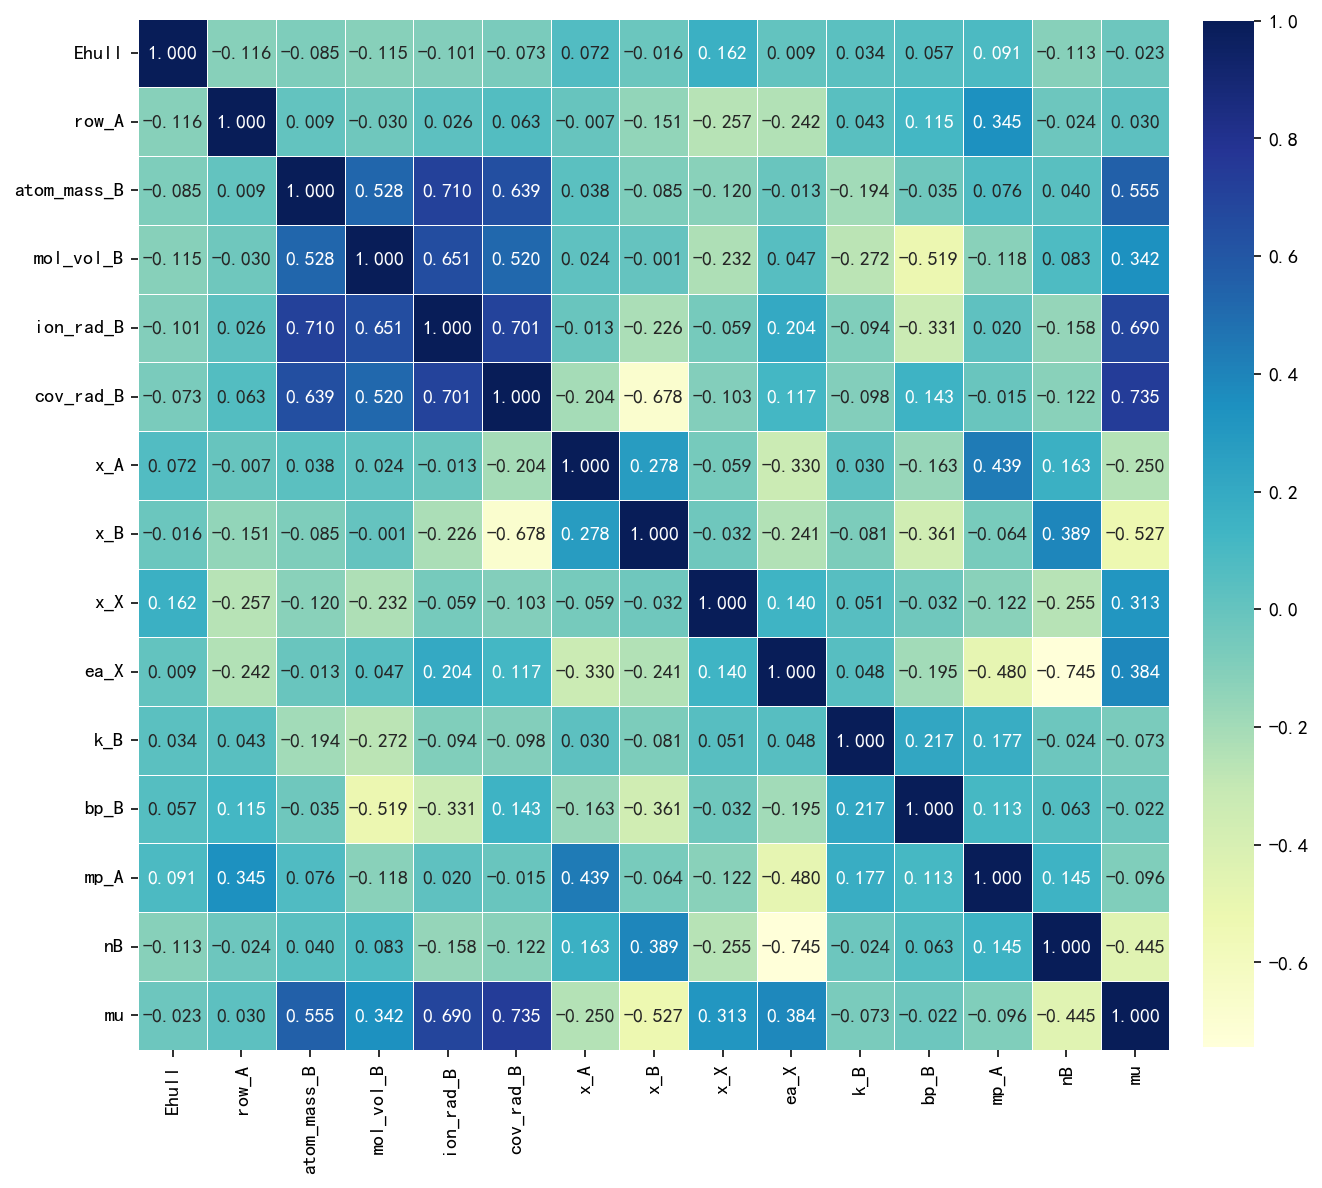

In [28]:
cor = plot_corrcoef_heatmap(new_X, fig_size=(10, 10))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    new_X, y, test_size=0.2, random_state=3
) 
model = gbr.fit(X_train, y_train)
    
GBR_test_pred = gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
RMSE = mean_squared_error(y_test, GBR_test_pred)**0.5
MAE = mean_absolute_error(y_test, GBR_test_pred)    

least_feature_list = ["first"] 
r2_list = [r2]          
RMSE_list = [RMSE]
MAE_list = [MAE]

print('r^2:', r2, '\nRMSE:', RMSE, '\nMAE:', MAE)

r^2: 0.9814136561109301 
RMSE: 0.10655730215924025 
MAE: 0.05816001580874158


In [30]:
scores = cross_val_score(gbr, X_train, y_train, cv=5)
print(scores)
print(scores.mean())

[0.97903445 0.97887006 0.96811088 0.97244568 0.99171525]
0.9780352651882473


In [31]:
print("delete features: ", len(delete_features), " residual features: ", len(new_X.columns))

# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
explainer.expected_value = explainer.expected_value[0]
shap_values = explainer(X_train) 
# shap_values = explainer.shap_values(X_train) # numpy.array

mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame(mean_abs_shap, columns=["mean_shap"], dtype=float)
shap_df = shap_df.sort_values(by="mean_shap") 
    
feature_names = X_train.columns
sorted_features = feature_names[shap_df.index]
print(sorted_features)

delete features:  52  residual features:  15
Index(['ea_X', 'k_B', 'ion_rad_B', 'mu', 'bp_B', 'nB', 'cov_rad_B', 'row_A',
       'mol_vol_B', 'Ehull', 'mp_A', 'atom_mass_B', 'x_A', 'x_B', 'x_X'],
      dtype='object')


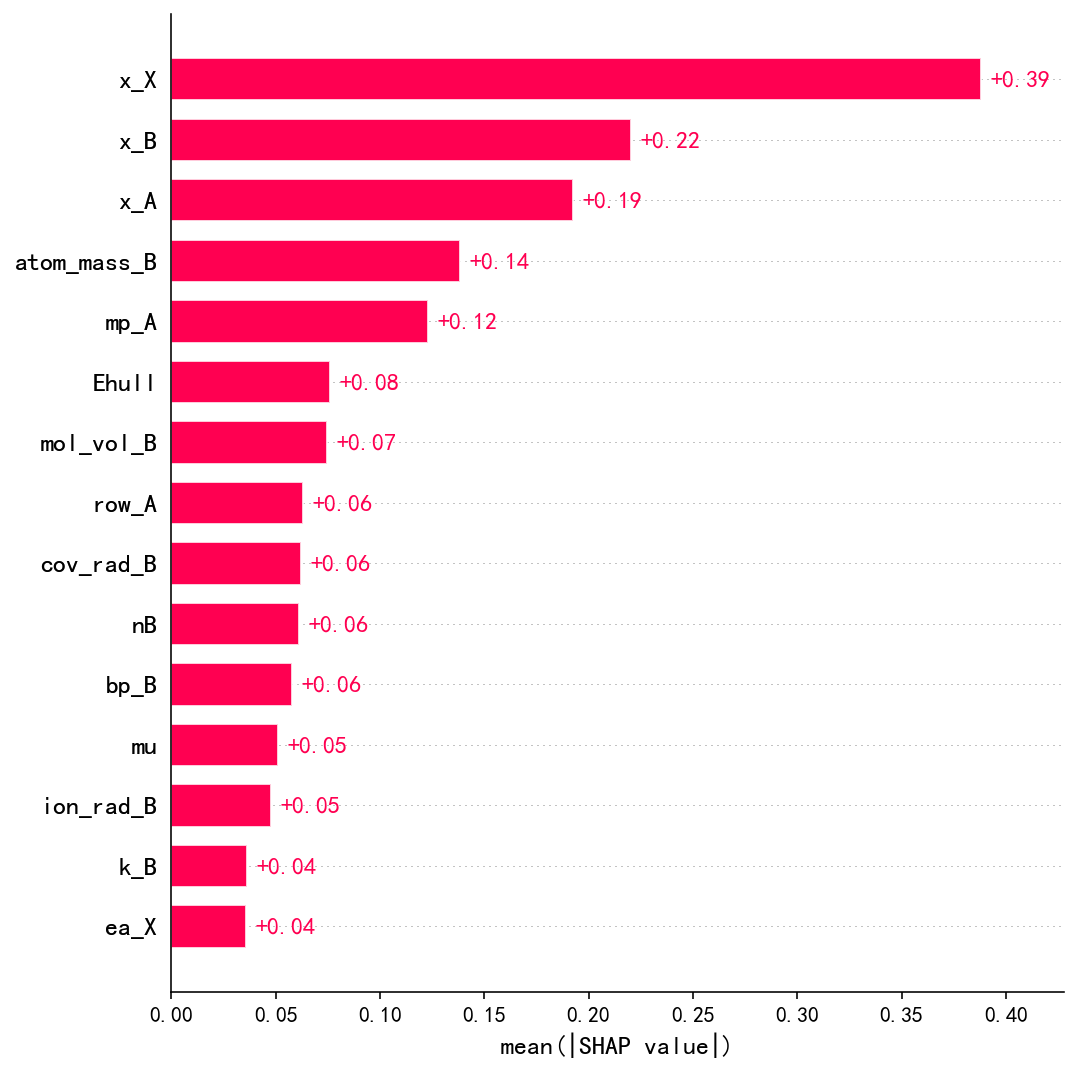

In [32]:
shap.plots.bar(shap_values, max_display=15)

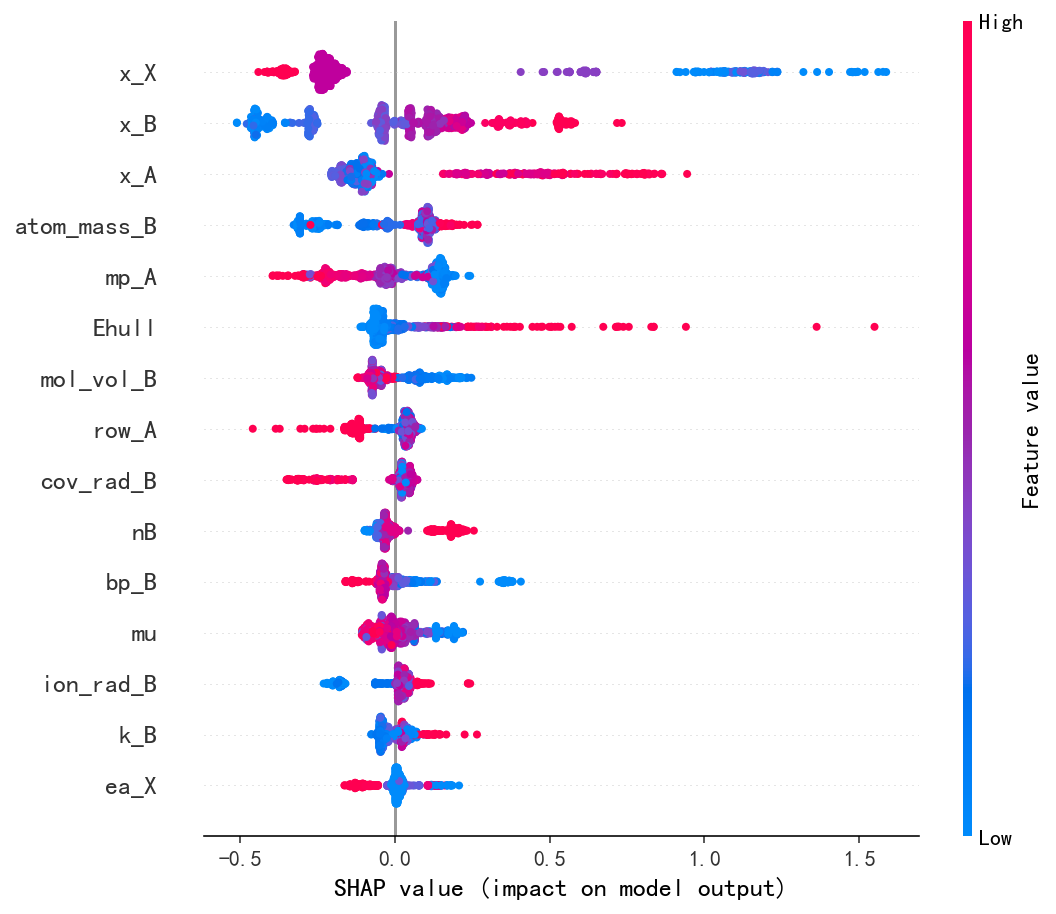

In [33]:
import copy    
shap.plots.beeswarm(copy.deepcopy(shap_values), max_display=15)

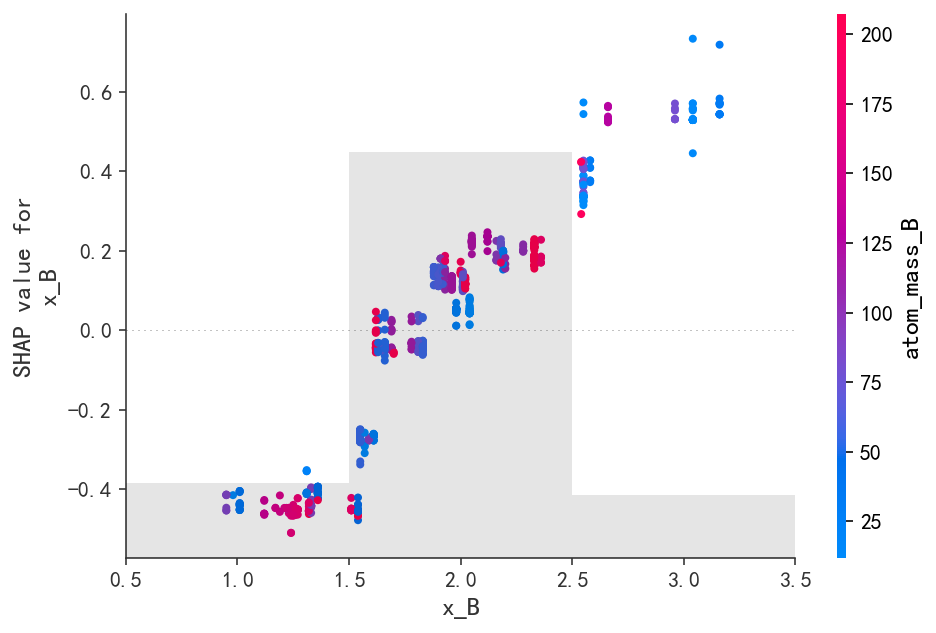

In [34]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"x_B"], color=shap_values[:,"atom_mass_B"])

findfont: Font family ['STSong'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STSong'] not found. Falling back to DejaVu Sans.


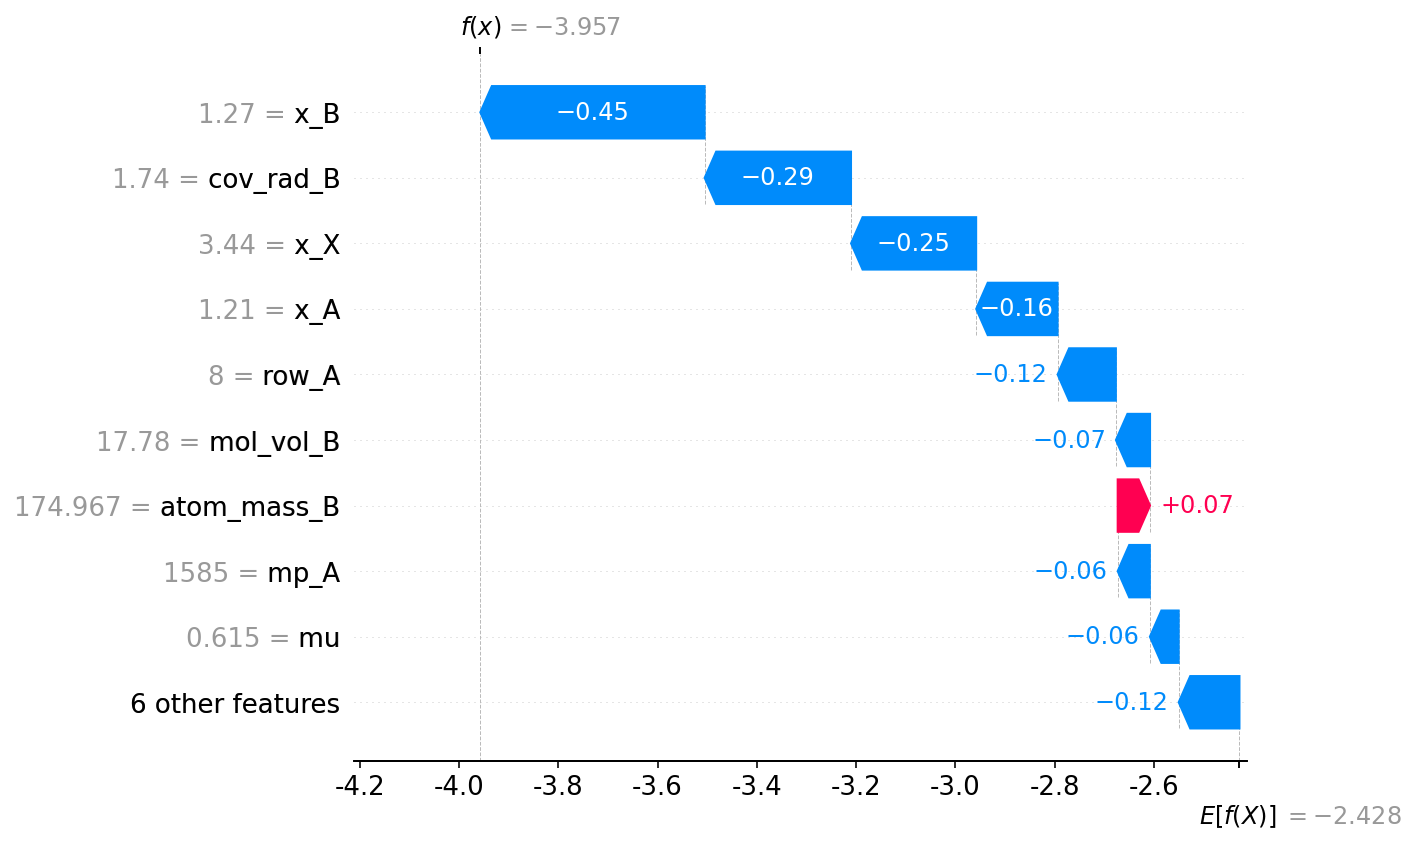

In [35]:
plt.rcParams["font.family"]="STSong"
plt.rcParams['axes.unicode_minus'] = False
shap.plots.waterfall(shap_values[1])

In [36]:
shap_sorted_index = np.argsort(mean_abs_shap)[-15:]
shap_importance = np.array(feature_names)[shap_sorted_index]
pos = np.arange(shap_sorted_index.shape[0]) + 0.5

In [37]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

config = {
    "font.family":'serif',
    "font.size": 15,
    "mathtext.fontset":'stix',
    "font.serif": ['Times New Roman'],
}
rcParams.update(config)

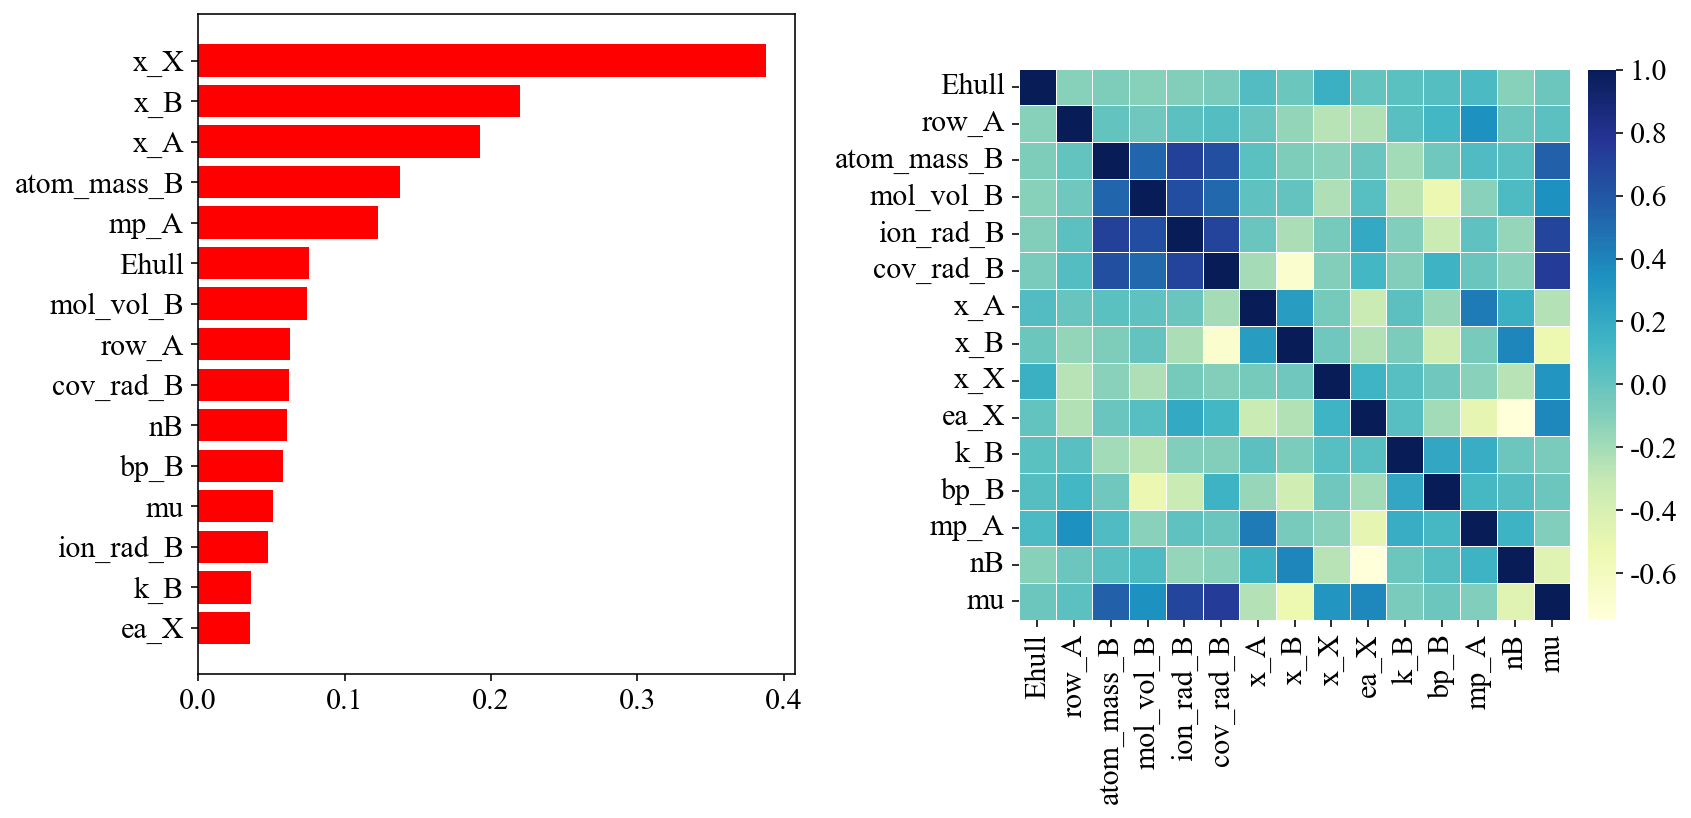

In [38]:
fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(pos, mean_abs_shap[shap_sorted_index], align="center", color="red")
plt.yticks(pos, shap_importance)
plt.xticks(fontproperties='Times New Roman', size=15)
plt.yticks(fontproperties='Times New Roman', size=15)

plt.subplot(1, 2, 2)
ax = sns.heatmap(data_cor,square=True,
                linewidths=.5,cmap="YlGnBu",
                cbar_kws={"fraction":0.046, "pad":0.03})
plt.xticks(fontproperties='Times New Roman', size=15)
plt.yticks(fontproperties='Times New Roman', size=15)

fig.tight_layout()
plt.show()

### band_gap prediction with Ehull
1.default parameters

In [39]:
X = data_1.drop(['band_gap', 'Ef'], axis=1)
print(type(X), X.shape)

y = data_1[['band_gap']].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3
)
print("training set: ",len(X_train)," test set: ",  len(X_test))

<class 'pandas.core.frame.DataFrame'> (1341, 67)
training set:  1072  test set:  269


In [40]:
tuned_params_gbr = {
    "random_state": [3]
}

In [41]:
params = {}
for k,v in tuned_params_gbr.items():
    params[k] = v[0]
gbr = ensemble.GradientBoostingRegressor(**params)

In [42]:
model = gbr.fit(X_train, y_train)

In [43]:
GBR_test_pred = gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
RMSE = mean_squared_error(y_test, GBR_test_pred)**0.5
MAE = mean_absolute_error(y_test, GBR_test_pred)
    
print('r^2:', r2, '\nRMSE:', RMSE, '\nMAE:', MAE)

r^2: 0.7588936235488949 
RMSE: 0.7421290481402983 
MAE: 0.5644475904201782


In [44]:
scores = cross_val_score(gbr, X_train, y_train, cv=5)
print(scores)
print(scores.mean())

[0.68810189 0.67890085 0.67317294 0.70269472 0.76703375]
0.7019808311421769


2.optimized parameters

In [45]:
tuned_params_gbr = {'random_state': [3],
                     'n_estimators': [1500],
                     'learning_rate': [0.06],
                     'max_depth': [3],
                     'min_samples_split': [2],
                     'min_samples_leaf': [1],
                     'max_features': [9]}

In [46]:
params = {}
for k,v in tuned_params_gbr.items():
    params[k] = v[0]
gbr = ensemble.GradientBoostingRegressor(**params)

In [47]:
model = gbr.fit(X_train, y_train)

In [48]:
GBR_test_pred = gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
RMSE = mean_squared_error(y_test, GBR_test_pred)**0.5
MAE = mean_absolute_error(y_test, GBR_test_pred)
    
print('r^2:', r2, '\nRMSE:', RMSE, '\nMAE:', MAE)

r^2: 0.8483604080057908 
RMSE: 0.5885473200092678 
MAE: 0.42402378258326684


In [49]:
scores = cross_val_score(gbr, X_train, y_train, cv=5)

In [50]:
print(scores)
print(scores.mean())

[0.75430684 0.72717328 0.7207134  0.79415485 0.87721069]
0.7747118113993172
